## Kickstarter Campaigns Analysis

In [2]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn import metrics
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

### Questions to answer:

* What's the best length of time to run a campaign?
* What's the ideal pledge goal?
* What type of projects would be most successful at getting funded?
* Is there an ideal month/day/time to launch a campaign?

### Load Data

In [8]:
data = pd.read_csv("https://s3-us-west-1.amazonaws.com/marketing-qubole/data/kickstarter/DSI_kickstarterscrape_dataset.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 12: invalid start byte

### Data Exploration

In [ ]:
data.shape

In [4]:
data.head()

NameError: name 'data' is not defined

In [5]:
data[["goal","pledged","duration","backers","funded percentage","levels"]].describe(percentiles=[.05, .10, .25, .5, .75])

NameError: name 'data' is not defined

In [6]:
print("Backers distribution")
sns.distplot(data.backers);

Backers distribution


NameError: name 'data' is not defined

In [7]:
print("Campaigns with >= 100 backers distribution")
sns.distplot(data[data.backers <= 100].backers);

Campaigns with >= 100 backers distribution


NameError: name 'data' is not defined

Duration distribution


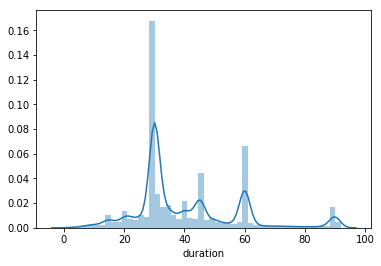

In [10]:
print("Duration distribution")
sns.distplot(data.duration);

Goal distribution


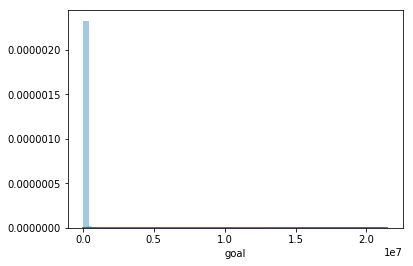

In [11]:
print("Goal distribution")
sns.distplot(data.goal);

Pledged distribution


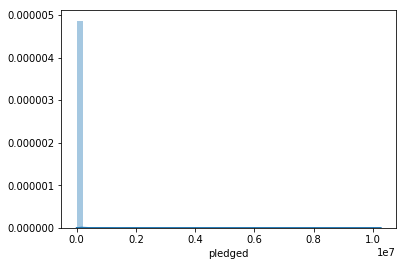

In [12]:
print("Pledged distribution")
sns.distplot(data[data.pledged>=0].pledged);

Funded percentage distribution


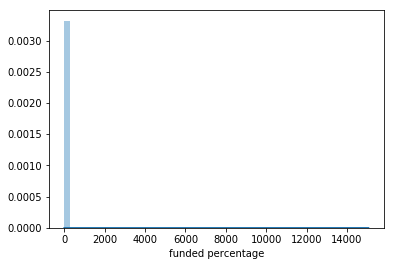

In [13]:
print("Funded percentage distribution")
sns.distplot(data["funded percentage"]);

Levels distribution


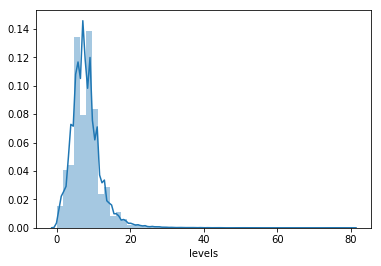

In [14]:
print("Levels distribution")
sns.distplot(data["levels"]);

Campaigns by status
successful    0.499793
failed        0.413343
live          0.085493
canceled      0.001284
suspended     0.000087
Name: status, dtype: float64


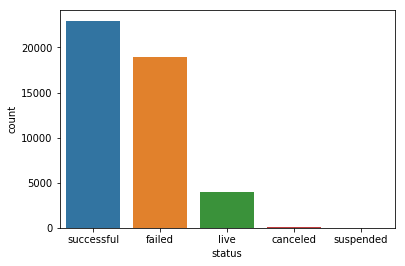

In [15]:
print("Campaigns by status")
print(data["status"].value_counts()/data["status"].count())
sns.countplot(data["status"]);

In [16]:
print("Examine funded percentage ranges")
data["funded_percent_int"] = data["funded percentage"].map(lambda d: int(d))

funded_bins = [0, 5, 10, 15, 20, 25, 50, 100, 1000]
funded_groups = ['0-5', '5-10', '10-15', '15-20','20-25','25-50','50-100','100-1000']
data['funded_percent_int_bins'] = pd.cut(data['funded_percent_int'], funded_bins, right=False, labels=funded_groups)
print(data['funded_percent_int_bins'].value_counts().sort_values(ascending=False)/data["funded_percent_int_bins"].count())

Examine funded percentage ranges
0-5         0.991011
5-10        0.005594
10-15       0.001197
15-20       0.000544
100-1000    0.000544
25-50       0.000479
20-25       0.000370
50-100      0.000261
Name: funded_percent_int_bins, dtype: float64


Examine duration vs campaign status
Best length of time to run a campaign: 30-60days


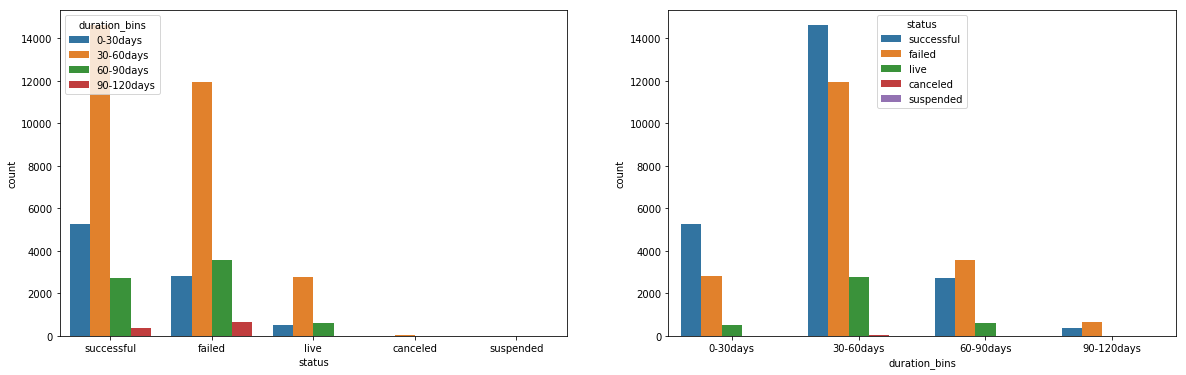

In [17]:
print("Examine duration vs campaign status")
data["duration_int"] = data.duration.map(lambda d: int(d))
# print(data["duration_int"].value_counts().sort_values(ascending=False).head())

# Define bins as 0 to 30, 30 to 60, 60 to 90, 90 to 120
days_bins = [0, 30, 60, 90, 120]
days_groups = ['0-30days', '30-60days', '60-90days', '90-120days']
data['duration_bins'] = pd.cut(data['duration_int'], days_bins, right=False, labels=days_groups)
# print(data['duration_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='duration_bins', ax=ax1)
sns.countplot(data=data, x='duration_bins',hue='status', ax=ax2);

print("Best length of time to run a campaign: 30-60days")

Examine goal vs campaign status
Ideal pledge goal: <= 5k


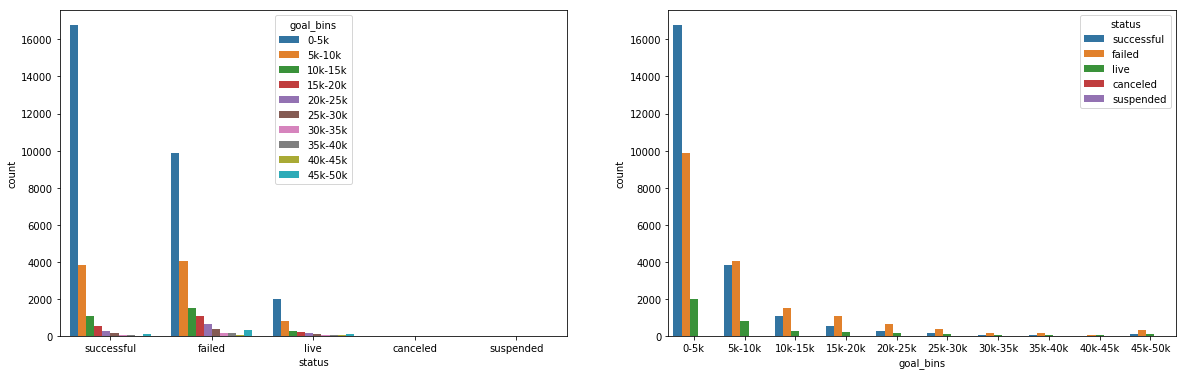

In [18]:
print("Examine goal vs campaign status")
goal_bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
goal_groups = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k', '35k-40k', '40k-45k', '45k-50k']
data['goal_bins'] = pd.cut(data['goal'], goal_bins, right=True, labels=goal_groups)
# print(data['goal_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='goal_bins', ax=ax1)
sns.countplot(data=data, x='goal_bins',hue='status', ax=ax2);

print("Ideal pledge goal: <= 5k")

Examine levels vs campaign status


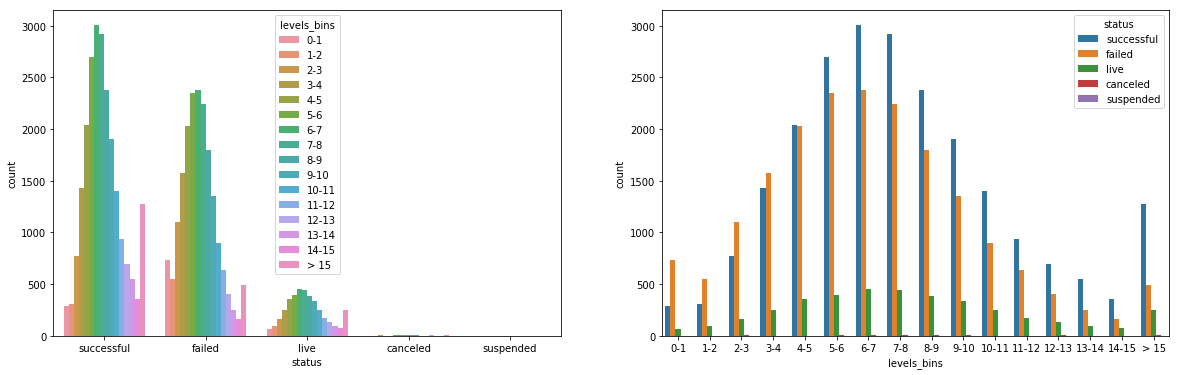

In [19]:
print("Examine levels vs campaign status")
levels_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1000]
levels_groups = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11', '11-12', '12-13', '13-14', '14-15', '> 15']
data['levels_bins'] = pd.cut(data['levels'], levels_bins, right=True, labels=levels_groups)
# print(data['levels_bins'].value_counts().sort_values(ascending=False))

f, (ax1, ax2) = sns.mpl.pyplot.subplots(1, 2, figsize=(20,6))
sns.countplot(data=data, x='status',hue='levels_bins', ax=ax1)
sns.countplot(data=data, x='levels_bins',hue='status', ax=ax2);

In [20]:
successful_campaigns = pd.DataFrame(data[data.status == "successful"])
print("Total successful campaigns: ", successful_campaigns.shape)

funded_campaigns = pd.DataFrame(successful_campaigns[successful_campaigns["funded percentage"] >= 100])
print("Total successful campaigns with >= 100% fund percentage: ", funded_campaigns.shape)

('Total successful campaigns: ', (22969, 23))
('Total successful campaigns with >= 100% fund percentage: ', (35, 23))


In [21]:
print("Examine funded percentage ranges for successful campaigns")
print(successful_campaigns['funded_percent_int_bins'].value_counts().sort_values(ascending=False)/successful_campaigns["funded_percent_int_bins"].count())

Examine funded percentage ranges for successful campaigns
0-5         0.983230
5-10        0.010454
10-15       0.002222
100-1000    0.001002
25-50       0.000958
15-20       0.000915
20-25       0.000697
50-100      0.000523
Name: funded_percent_int_bins, dtype: float64


Successful campaigns by category


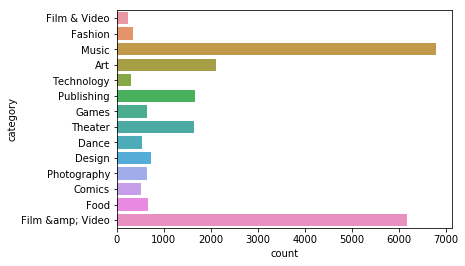

In [22]:
print("Successful campaigns by category")
sns.countplot(y=successful_campaigns["category"]);

Successful funded campaigns by category


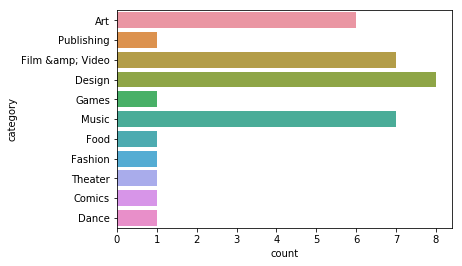

In [23]:
print("Successful funded campaigns by category")
sns.countplot(y=funded_campaigns["category"]);

Successful campaigns by location


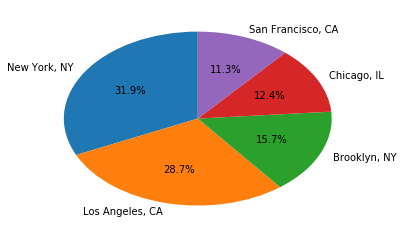

In [24]:
print("Successful campaigns by location")

top_locations = pd.DataFrame(successful_campaigns["location"].value_counts().sort_values(ascending=False).head().reset_index())
top_locations.columns = ["location","count"]

plt.pie(
    top_locations['count'],
    labels=top_locations['location'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by location


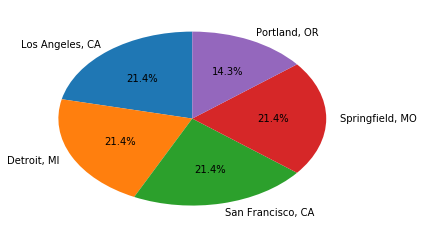

In [25]:
print("Successful funded campaigns by location")

top_locations = pd.DataFrame(funded_campaigns["location"].value_counts().sort_values(ascending=False).head().reset_index())
top_locations.columns = ["location","count"]

plt.pie(
    top_locations['count'],
    labels=top_locations['location'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

In [26]:
print("Successful campaigns by category and sub category")
successful_campaigns.groupby(['category', 'subcategory']).size()

Successful campaigns by category and sub category


category          subcategory           
Art               Art                        610
                  Conceptual Art              97
                  Digital Art                 65
                  Illustration               111
                  Mixed Media                198
                  Painting                   242
                  Performance Art            270
                  Public Art                 335
                  Sculpture                  178
Comics            Comics                     520
Dance             Dance                      527
Design            Crafts                     105
                  Design                     133
                  Graphic Design              97
                  Product Design             394
Fashion           Fashion                    335
Film & Video      Animation                    4
                  Documentary                 63
                  Film &amp; Video            33
                  Narrative 

In [27]:
print("Successful funded campaigns by category and sub category")
funded_campaigns.groupby(['category', 'subcategory']).size()

Successful funded campaigns by category and sub category


category          subcategory           
Art               Art                       2
                  Conceptual Art            2
                  Sculpture                 2
Comics            Comics                    1
Dance             Dance                     1
Design            Crafts                    1
                  Graphic Design            4
                  Product Design            3
Fashion           Fashion                   1
Film &amp; Video  Documentary               1
                  Film &amp; Video          1
                  Narrative Film            4
                  Short Film                1
Food              Food                      1
Games             Board &amp; Card Games    1
Music             Classical Music           2
                  Country &amp; Folk        2
                  Indie Rock                2
                  Music                     1
Publishing        Publishing                1
Theater           Theater              

Successful campaigns by business day or weekend


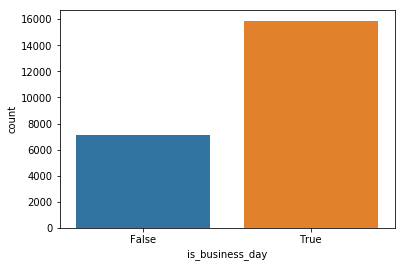

In [28]:
print("Successful campaigns by business day or weekend")
successful_campaigns["funded_dt"] = pd.to_datetime(successful_campaigns["funded date"])
successful_campaigns["is_business_day"] = np.is_busday(successful_campaigns.funded_dt.values.astype('datetime64[D]'))
sns.countplot(successful_campaigns["is_business_day"]);

Successful funded campaigns by business day or weekend


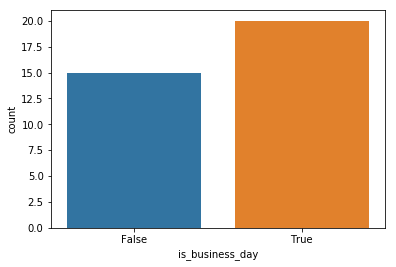

In [29]:
print("Successful funded campaigns by business day or weekend")
funded_campaigns["funded_dt"] = pd.to_datetime(funded_campaigns["funded date"])
funded_campaigns["is_business_day"] = np.is_busday(funded_campaigns.funded_dt.values.astype('datetime64[D]'))
sns.countplot(funded_campaigns["is_business_day"]);

Successful campaigns by day of the week


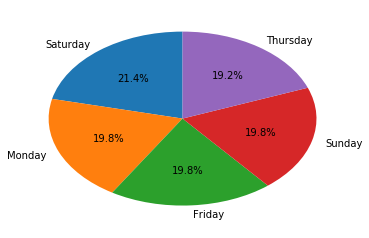

In [30]:
print("Successful campaigns by day of the week")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.strftime("%A").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["day","count"]

plt.pie(
    df['count'],
    labels=df['day'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by day of the week


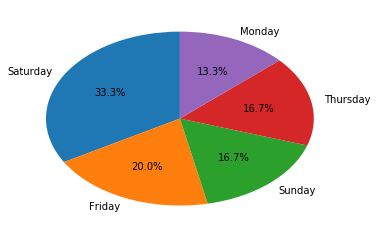

In [31]:
print("Successful funded campaigns by day of the week")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.strftime("%A").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["day","count"]

plt.pie(
    df['count'],
    labels=df['day'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful campaigns by month


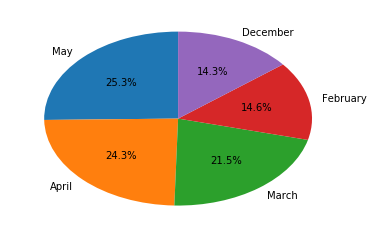

In [32]:
print("Successful campaigns by month")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.strftime("%B").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["month","count"]

plt.pie(
    df['count'],
    labels=df['month'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by month


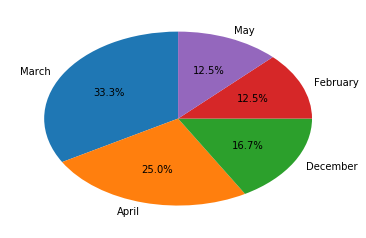

In [33]:
print("Successful funded campaigns by month")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.strftime("%B").value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["month","count"]

plt.pie(
    df['count'],
    labels=df['month'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful campaigns by hour


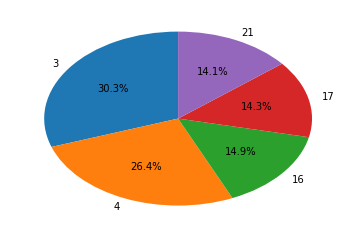

In [34]:
print("Successful campaigns by hour")

df = pd.DataFrame(successful_campaigns["funded_dt"].dt.hour.value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["hour","count"]

plt.pie(
    df['count'],
    labels=df['hour'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

Successful funded campaigns by hour


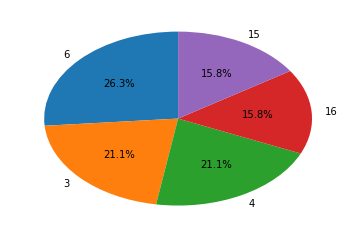

In [35]:
print("Successful funded campaigns by hour")

df = pd.DataFrame(funded_campaigns["funded_dt"].dt.hour.value_counts().sort_values(ascending=False).head().reset_index())
df.columns = ["hour","count"]

plt.pie(
    df['count'],
    labels=df['hour'],
    # with no shadows
    shadow=False,
    # with the start angle at 90%
    startangle=90,
    # with the percent listed as a fraction
    autopct='%1.1f%%',);

### Modeling

In [36]:
data = pd.read_csv("https://s3-us-west-1.amazonaws.com/marketing-qubole/data/kickstarter/DSI_kickstarterscrape_dataset.csv")
clean_data = data.copy()

# Inspect columns with missing values
# print("Columns with missing values:")
# print(clean_data.isnull().any())
# Check for # of missing values per column
# print(clean_data.isnull().sum())

# Delete samples with missing values
clean_data_nonnull = clean_data.dropna()
print("Fraction of data kept:\n",float(clean_data_nonnull.shape[0])/clean_data.shape[0])
clean_data = clean_data_nonnull

('Fraction of data kept:\n', 0.9700372086950846)


In [37]:
data.head()

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,"Mon, 02 Aug 2010 03:59:00 -0000",5,"$1,$5,$10,$25,$50",6,0,47.18
2,138119,STRUM,http://www.kickstarter.com/projects/185476022/...,Film & Video,Animation,"Los Angeles, CA",live,20000.0,56.0,0.002800,3,"Fri, 08 Jun 2012 00:00:31 -0000",10,"$1,$10,$25,$40,$50,$100,$250,$1,000,$1,337,$9,001",1,0,28.00
3,237090,GETTING OVER - One son's search to finally kno...,http://www.kickstarter.com/projects/charnick/g...,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,"Sun, 08 Apr 2012 02:14:00 -0000",13,"$1,$10,$25,$30,$50,$75,$85,$100,$110,$250,$500...",4,0,32.22
4,246101,The Launch of FlyeGrlRoyalty &quot;The New Nam...,http://www.kickstarter.com/projects/flyegrlroy...,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,"Wed, 01 Jun 2011 15:25:39 -0000",6,"$10,$25,$50,$100,$150,$250",2,0,30.00


In [38]:
# Drop columns we don't need for modeling
del clean_data["project id"]
del clean_data["name"]
del clean_data["url"]
del clean_data["subcategory"]
del clean_data["reward levels"]
del clean_data["funded date"]
del clean_data["pledged"]
del clean_data["backers"]

In [39]:
clean_data.head(20)

,category,location,status,goal,funded percentage,levels,updates,comments,duration
0,Film & Video,"Columbia, MO",successful,10500.0,1.099524,7,10,2,30.00
1,Games,"Maplewood, NJ",failed,4000.0,0.005000,5,6,0,47.18
2,Film & Video,"Los Angeles, CA",live,20000.0,0.002800,10,1,0,28.00
3,Film & Video,"Los Angeles, CA",successful,6000.0,1.089167,13,4,0,32.22
4,Fashion,"Novi, MI",failed,3500.0,0.000000,6,2,0,30.00
5,Film & Video,"Portland, OR",successful,3500.0,1.023331,7,8,0,21.43
6,Film & Video,"Collegedale, TN",failed,1000.0,0.280000,5,0,0,30.00
7,Fashion,"Chicago, IL",successful,2000.0,1.090000,7,13,5,30.00
8,Music,"Chicago, IL",successful,1000.0,1.125000,12,10,1,67.53
9,Art,"Chicago, IL",successful,7500.0,1.311527,10,6,5,35.29


In [40]:
# one-hot code category
category_onehot_coded = clean_data.category.str.get_dummies()
clean_data = clean_data.merge(category_onehot_coded,left_index=True,right_index=True)
del clean_data["category"]

In [41]:
# one-hot code location
popular_locations = clean_data.location.value_counts(ascending=False).head(5)
print("Top 5 locations: ",popular_locations)

def loction_bucket(location):
    if location in popular_locations:
        return location
    
    return "OtherLocation"

clean_data.loc[:,("location")] = clean_data["location"].apply(loction_bucket)
location_onehot_coded = clean_data.location.str.get_dummies()
clean_data = clean_data.merge(location_onehot_coded,left_index=True,right_index=True)
del clean_data["location"]

('Top 5 locations: ', Los Angeles, CA      3923
New York, NY         3634
Brooklyn, NY         1612
Chicago, IL          1492
San Francisco, CA    1350
Name: location, dtype: int64)


In [42]:
# scale goal
clean_goal_data = clean_data.goal.values.reshape(-1, 1)

# Scale clean_data.goal
scaler = StandardScaler() #create a scaler object
scaler.fit_transform(clean_goal_data) #fit the scaler
clean_goal_data_scaled = scaler.transform(clean_goal_data) #transform the data with it

# # compare original to standardized
# print("original values:\n",clean_goal_data[:10],"\n")
# print("scaled values:\n",clean_goal_data_scaled[:10],"\n")

# figure out how the standardization worked
print("Mean of column:\n",scaler.mean_,"\n")
print("standard deviation of column:\n",scaler.scale_,"\n")
print("Final Means of scaled data:\n",clean_goal_data_scaled.mean(axis=0))
print("Final standard deviation of scaled data:\n",clean_goal_data_scaled.std(axis=0))

clean_data.loc[:,("goal")] = clean_goal_data_scaled

print("Goal min value: ",clean_data.goal.min())
print("Goal max value: ",clean_data.goal.max())

('Mean of column:\n', array([ 12086.52264109]), '\n')
('standard deviation of column:\n', array([ 191613.64464607]), '\n')
('Final Means of scaled data:\n', array([ -1.91263186e-18]))
('Final standard deviation of scaled data:\n', array([ 1.]))
('Goal min value: ', -0.063074958275641482)
('Goal max value: ', 112.01055116404908)


In [43]:
# set outcome to 1 = succesful, 0 = everything else
clean_data.loc[:,('outcome')] = (clean_data.status=='successful').astype(int)
del clean_data["status"]
print(clean_data.outcome.value_counts())

1    22322
0    22258
Name: outcome, dtype: int64


In [44]:
clean_data.head(20)

,goal,funded percentage,levels,updates,comments,duration,Art,Comics,Dance,Design,...,Publishing,Technology,Theater,"Brooklyn, NY","Chicago, IL","Los Angeles, CA","New York, NY",OtherLocation,"San Francisco, CA",outcome
0,-0.008280,1.099524,7,10,2,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,-0.042202,0.005000,5,6,0,47.18,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.041299,0.002800,10,1,0,28.00,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.031765,1.089167,13,4,0,32.22,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.044812,0.000000,6,2,0,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,-0.044812,1.023331,7,8,0,21.43,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
6,-0.057859,0.280000,5,0,0,30.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,-0.052640,1.090000,7,13,5,30.00,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,-0.057859,1.125000,12,10,1,67.53,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,-0.023936,1.311527,10,6,5,35.29,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


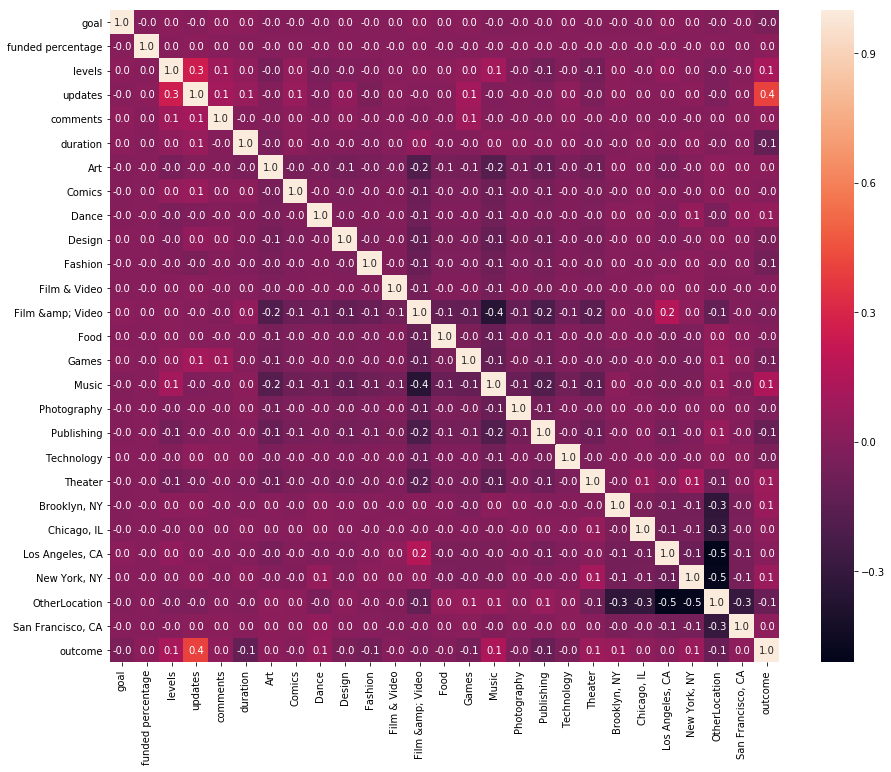

In [45]:
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.heatmap(clean_data.corr(),annot=True, fmt=".1f");

#### Logistic Regression

In [46]:
selected_features = clean_data.columns.tolist()[:-1] # excluding last 'outcome' column

all_features_X = clean_data[selected_features]
all_y = clean_data.outcome

# for n in [0.3,0.2,0.1]:
for n in [0.2]:
    all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(all_features_X,all_y,test_size=n,random_state=1)
    
    logreg_all = LogisticRegression(C=1e9)
    logreg_all.fit(all_X_train,all_y_train)

    dumb_model = DummyClassifier(strategy='most_frequent')
    dumb_model.fit(all_X_train, all_y_train)
    y_dumb_class = dumb_model.predict(all_X_test)

    print("### Data split {0}/{1} with all features ###".format(int((1-n) * 100),int(n * 100)))
    print("Bias coefficient (intercept): {0}".format(logreg_all.intercept_[0]))
    print("Model accuracy on {0}% training data: {1}".format(int((1-n) * 100),metrics.accuracy_score(all_y_train,logreg_all.predict(all_X_train))))
    all_y_test_pred = logreg_all.predict(all_X_test)
    print("Model accuracy on {0}% test data: {1}".format(int(n * 100),metrics.accuracy_score(all_y_test,all_y_test_pred)))
    print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(all_y_test, y_dumb_class))
    print("F1 Score:\n", metrics.f1_score(all_y_test,all_y_test_pred))
    print("\r") 
    print("Features in order of their absolute coefficient values--indicating their importance")
    feature_coeff_df = pd.DataFrame(list(zip(clean_data.columns.tolist()[1:],logreg_all.coef_[0],abs(logreg_all.coef_[0]))),columns=["feature","coefficient","abs_coefficient"])
    print(feature_coeff_df.sort_values(['abs_coefficient'],ascending=False))
    
    print("\n")


### Data split 80/20 with all features ###
Bias coefficient (intercept): -3.64790932613
Model accuracy on 80% training data: 0.980596680126
Model accuracy on 20% test data: 0.979475100942
('Most frequent class dummy classifier test accuracy: ', 0.49506505159264241)
('F1 Score:\n', 0.98005449591280647)

Features in order of their absolute coefficient values--indicating their importance
              feature  coefficient  abs_coefficient
1              levels     5.728995         5.728995
0   funded percentage    -5.224882         5.224882
14              Music    -1.706376         1.706376
7               Dance    -0.920117         0.920117
9             Fashion    -0.887882         0.887882
24  San Francisco, CA    -0.840633         0.840633
18            Theater    -0.733201         0.733201
22       New York, NY    -0.708279         0.708279
21    Los Angeles, CA    -0.700190         0.700190
25            outcome    -0.672717         0.672717
8              Design     0.523965      

Notes: 
* If bias coefficient (intercept) is positive, knowing nothing else means assume class 1. If negative, assume class 0.
* Positive feature coefficients increase the log-odds of the response being 1 (and thus increase the probability), and negative feature coefficients decrease the log-odds of the response being 1 (and thus decrease the probability).
* In other words, negative feature coefficients forces outcome closer to 0; Positive feature coefficients forces outcome closer to 1.

#### Decision Tree

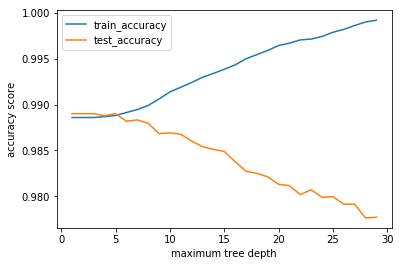

In [47]:
X_train,X_test,y_train,y_test = train_test_split(all_features_X,all_y,test_size=.3,random_state=1)

depths = range(1,30)
train_accuracy, test_accuracy = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_accuracy = metrics.accuracy_score(y_train,decision_tree.predict(X_train))
    y_test_pred = decision_tree.predict(X_test)
    curr_test_accuracy = metrics.accuracy_score(y_test,y_test_pred)
    train_accuracy.append(curr_train_accuracy)
    test_accuracy.append(curr_test_accuracy)
#     print("F1 Score:\n", metrics.f1_score(y_test,y_test_pred))
    
sns.mpl.pyplot.plot(depths,train_accuracy,label='train_accuracy')
sns.mpl.pyplot.plot(depths,test_accuracy,label='test_accuracy')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("accuracy score")
sns.mpl.pyplot.legend();

In [48]:
#DecisionTreeClassifier based on the best max_depth observed above
best_single_tree = DecisionTreeClassifier(max_depth=5, random_state=1)
best_single_tree.fit(X_train,y_train)
best_single_tree_y_pred = best_single_tree.predict(X_test)
print("Best Decision Tree Accuracy Score:",metrics.accuracy_score(y_test,best_single_tree_y_pred))

dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))
print("F1 Score: ", metrics.f1_score(y_test,best_single_tree_y_pred))

('Best Decision Tree Accuracy Score:', 0.98900852400179451)
('Most frequent class dummy classifier test accuracy: ', 0.49700912217735904)
('F1 Score: ', 0.98919038164570927)


In [49]:
#Compute the feature importances
feature_imp = pd.DataFrame({'feature':X_train.columns.tolist(), 'importance':best_single_tree.feature_importances_})
print(feature_imp.sort_values("importance",ascending=False)) 

              feature  importance
1   funded percentage    0.997632
4            comments    0.000682
3             updates    0.000613
9              Design    0.000461
2              levels    0.000343
14              Games    0.000140
5            duration    0.000065
7              Comics    0.000043
0                goal    0.000020
20       Brooklyn, NY    0.000000
19            Theater    0.000000
23       New York, NY    0.000000
21        Chicago, IL    0.000000
22    Los Angeles, CA    0.000000
17         Publishing    0.000000
24      OtherLocation    0.000000
18         Technology    0.000000
13               Food    0.000000
16        Photography    0.000000
15              Music    0.000000
12   Film &amp; Video    0.000000
11       Film & Video    0.000000
10            Fashion    0.000000
8               Dance    0.000000
6                 Art    0.000000
25  San Francisco, CA    0.000000


#### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=20) #random forest with 20 trees

# Compute cross-validation score accuracy across 10 folds
cross_val_scores = cross_val_score(rf,all_features_X,all_y,cv=10)
print("10-fold accuracies:\n",cross_val_scores)
print("Mean cv-accuracy:",np.mean(cross_val_scores))
print("Std of cv-accuracy:",np.std(cross_val_scores))